In [1]:
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import sys
import os
import config as cfg
import numpy as np
import time
import multiprocessing
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score



sys.path.append(r"C:\Users\safou\OneDrive\Bureau\iridia-af-main\iridia_af")

import hyperparameters as hp
from record import Record

In [2]:
dataset_path = Path(hp.DATASET_PATH, f"dataset_hrv_{cfg.WINDOW_SIZE}_{cfg.TRAINING_STEP}.csv")
dataset = pd.read_csv(dataset_path)
print(dataset)

          mean_nni       sdnn       sdsd  nni_50    pnni_50  nni_20  \
0       764.133333  94.663630  35.918720      19   6.354515      65   
1       722.841667  50.851322  33.526178      17   5.685619      71   
2       714.025000  48.283100  38.653695      22   7.357860      89   
3       726.450000  59.291927  39.320096      32  10.702341     100   
4       738.900000  58.737754  44.043039      37  12.374582     120   
...            ...        ...        ...     ...        ...     ...   
310770  481.375000  80.907562  76.027531     165  55.183946     249   
310771  477.458333  82.742614  78.727349     167  55.852843     245   
310772  481.133333  93.300270  85.324228     174  58.193980     248   
310773  481.866667  91.585207  84.588491     167  55.852843     244   
310774  485.766667  96.109933  85.870391     180  60.200669     245   

          pnni_20      rmssd  median_nni  range_nni  ...       hfnu  \
0       21.739130  35.930070      745.00      695.0  ...  26.632166   
1    

In [3]:
# Verify categorical columns
categorical_columns = dataset.select_dtypes(include=['category', 'object']).columns
if len(categorical_columns) > 0:
    print("The following categorical columns were found:")
    print(categorical_columns)
else:
    print("No categorical columns found.")


The following categorical columns were found:
Index(['patient', 'record'], dtype='object')


In [4]:
#df_af = dataset[dataset['label'] == 1] # ECG containing AF episode
#X = df_af.drop(columns=["label", "patient", "record"])

X = dataset.drop(columns=["label", "patient", "record"])
df_af = X.copy()

In [5]:
# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [6]:
# Apply K-means clustering
kmeans = KMeans(n_clusters=3)
clusters = kmeans.fit_predict(X_scaled)

df_af.loc[:, 'cluster'] = clusters
df_af.head()



,mean_nni,sdnn,sdsd,nni_50,pnni_50,nni_20,pnni_20,rmssd,median_nni,range_nni,...,lf_hf_ratio,lfnu,hfnu,total_power,vlf,triangular_index,sd1,sd2,ratio_sd2_sd1,cluster
0,764.133333,94.663630,35.918720,19,6.354515,65,21.739130,35.930070,745.0,695.0,...,2.754858,73.367834,26.632166,3340.577759,1907.401682,6.382979,25.440950,131.435018,5.166278,1
1,722.841667,50.851322,33.526178,17,5.685619,71,23.745819,33.526683,725.0,645.0,...,2.404000,70.622798,29.377202,2006.842107,537.419696,6.521739,23.746331,67.880967,2.858588,1
2,714.025000,48.283100,38.653695,22,7.357860,89,29.765886,38.654741,715.0,680.0,...,0.538521,35.002508,64.997492,643.572570,118.459565,7.142857,27.378111,62.553613,2.284804,1
3,726.450000,59.291927,39.320096,32,10.702341,100,33.444816,39.320100,715.0,720.0,...,0.619634,38.257654,61.742346,1268.442764,405.926858,7.142857,27.850118,79.091315,2.839892,1
4,738.900000,58.737754,44.043039,37,12.374582,120,40.133779,44.043153,740.0,720.0,...,0.523270,34.351741,65.648259,1608.099190,612.979295,9.677419,31.195341,76.987650,2.467921,1


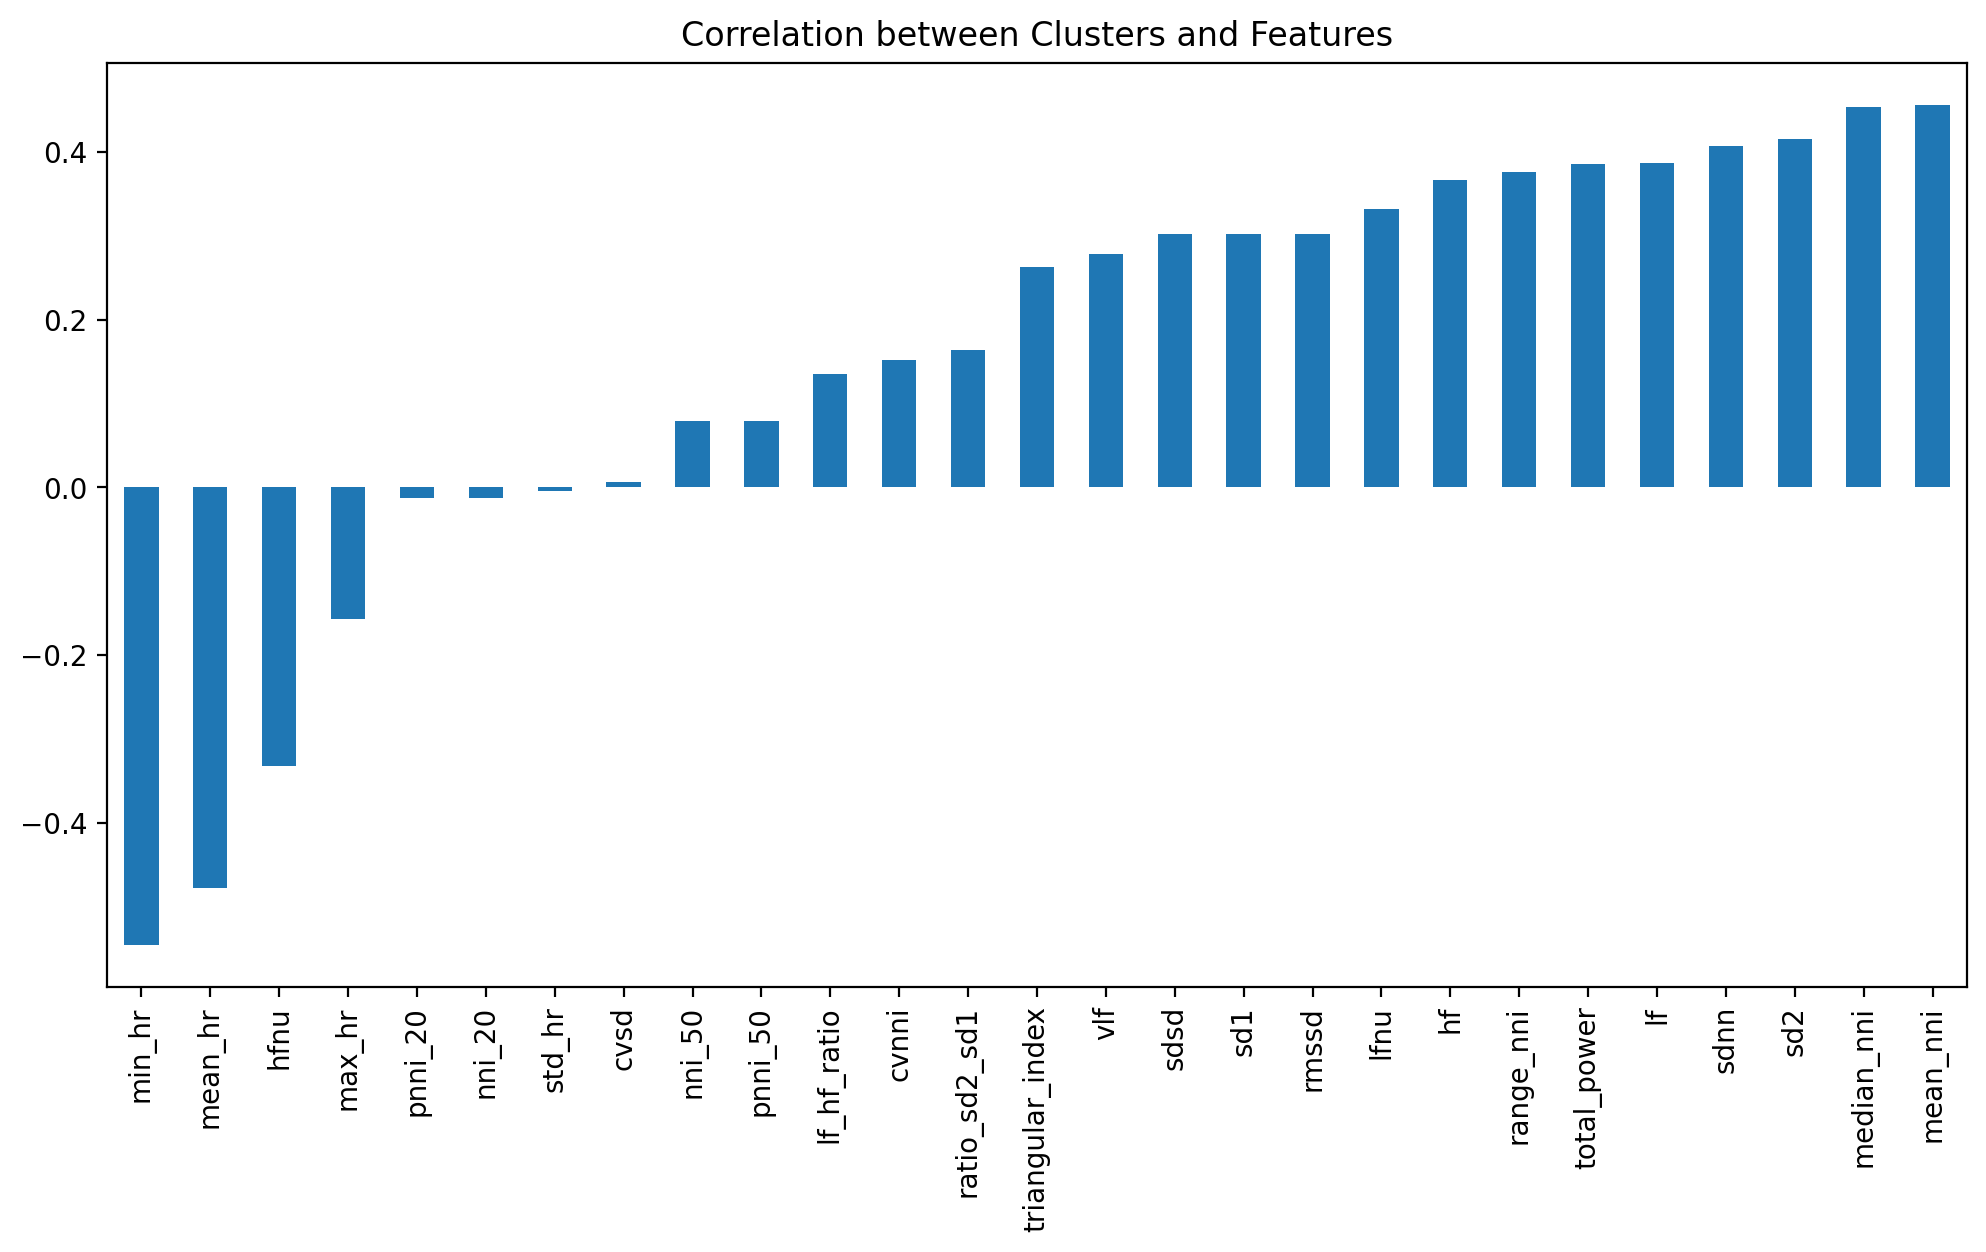

In [7]:
# Look at correlations of each feature with assigned cluster (allow to identify which features contribute most to the formation of clusters)
plt.figure(figsize=(12,6),dpi=200)
df_af.corr()["cluster"].iloc[:-1].sort_values().plot(kind="bar")
plt.title("Correlation between Clusters and Features")
plt.show()

In [10]:
# Elbow Curve Method
ssd = []  # sum of squared distance
MIN_CLUSTERS = 2
MAX_CLUSTERS = 10
for k in range(MIN_CLUSTERS,MAX_CLUSTERS):
    
    print(f"{k}/{MAX_CLUSTERS}")
    start_time = time.time()
    
    model = KMeans(n_clusters=k)
    clusters = model.fit_predict(X_scaled)
    X['cluster'] = clusters
    
    # Compute the sum of squared distance 
    ssd.append(model.inertia_)
    
    score = silhouette_score(X_scaled, clusters)
    print(f'Silhouette Score: {score}') # Higher score indicates better-defined clusters
    
    # Timing of curr iteration
    end_time = time.time()
    iteration_time = end_time - start_time
    print(f"Time for k={k}: {iteration_time:.4f} seconds")

plt.plot(range(2,10),ssd,"o--")
plt.title("Elbow Range")
plt.show()

2/10


KeyboardInterrupt: 

In [ ]:
# Define a function to perform k-means clustering and calculate SSD
def kmeans_for_k(k, X_scaled):
    start_time = time.time()
    
    model = KMeans(n_clusters=k)
    model.fit(X_scaled)
    ssd = model.inertia_  # SSD (Sum of Squared Distances)
    
    end_time = time.time()
    iteration_time = end_time - start_time
    
    print(f"Time for k={k}: {iteration_time:.4f} seconds")
    return k, ssd, iteration_time


# Elbow Curve Method parameters
MIN_CLUSTERS = 2
MAX_CLUSTERS = 10
k_values = range(MIN_CLUSTERS, MAX_CLUSTERS)

# Using a multiprocessing pool to parallelize the tasks
with multiprocessing.Pool() as pool:
    results = pool.starmap(kmeans_for_k, [(k, X_scaled) for k in k_values])

# Collect the results
k_list, ssd_list, times = zip(*results)

# Plot the SSD values for the elbow curve
plt.plot(k_list, ssd_list, "o--")
plt.title("Elbow Curve")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Sum of Squared Distances (SSD)")
plt.show()




In [ ]:
model = KMeans(n_clusters=2)
clusters = model.fit_predict(X_scaled)
X['cluster'] = clusters

# Count samples in each cluster
cluster_series = pd.Series(clusters)
print("Cluster counts:\n", cluster_series.value_counts().sort_index())


In [ ]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)


In [ ]:
#  optimal nb of clusters deterimined by elbow method
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis')
plt.title('PCA of AF Clusters')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()